In [2]:
import pandas as pd
import numpy as np
import wget
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [43]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
wget.download(url)

'course_lead_scoring.csv'

In [63]:
df = pd.read_csv('course_lead_scoring.csv')

In [64]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [65]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [66]:
cat_features = list(df.dtypes[df.dtypes == 'object'].index)

In [67]:
num_features = ['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [68]:
df[cat_features] = df[cat_features].fillna('NA')

In [69]:
df[num_features] = df[num_features].fillna(0)

In [70]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [81]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


Splitting data

In [71]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [72]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [73]:
y_train = df_train.converted
y_val = df_val.converted
y_test = df_test.converted

In [74]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

Question 1: ROC AUC feature importance <br>
ROC AUC could also be used to evaluate feature importance of numerical variables.<br>

<br>

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth. <br>
Use the training dataset for that <br>
If your AUC is < 0.5, invert this variable by putting "-" in front <br>

(e.g. -df_train['balance']) <br>

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive. <br>

Which numerical variable (among the following 4) has the highest AUC? <br>

lead_score <br>
number_of_courses_viewed <br>
interaction_count <br>
annual_income <br>

In [75]:
for num in num_features:
    auc = roc_auc_score(y_train, df_train[num])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[num])
    print('%9s, %.3f' % (num, auc))

number_of_courses_viewed, 0.764
annual_income, 0.552
interaction_count, 0.738
lead_score, 0.614


Question 1: number_of_courses_viewed

Question 2: Training the model <br>
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:<br>
<br>
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [76]:
df_train.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score'],
      dtype='object')

In [77]:
train_dicts = df_train[cat_features + num_features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)

In [78]:
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[cat_features + num_features].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [79]:
roc_auc_score(y_val, y_pred)

0.8171316268814112

In [80]:
round(roc_auc_score(y_val, y_pred),3)

0.817

Question 3: Precision and Recall <br>
Now let's compute precision and recall for our model. <br>

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01 <br>
For each threshold, compute precision and recall <br>
Plot them <br>

In [82]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores


df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


In [83]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

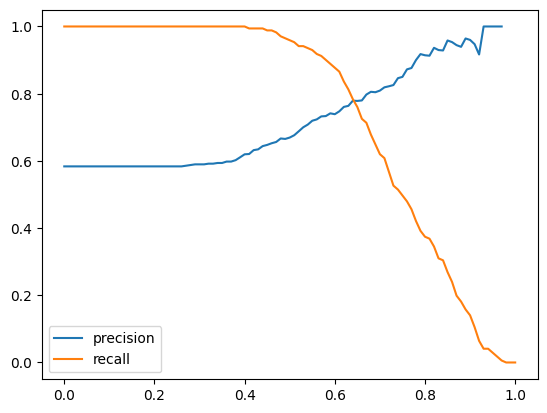

In [85]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.legend()
plt.show()

Q3: 0.745

Question 4: F1 score <br>
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both <br>
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 <br>

At which threshold F1 is maximal? <br>

In [86]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

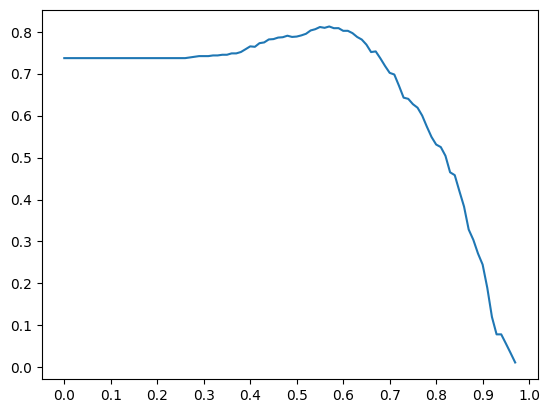

In [87]:
plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

Q4: 0.54

Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

In [88]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cat_features + num_features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[cat_features + num_features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [90]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted
    y_val = df_val.converted

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


Q5: 0.36

In [93]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted
        y_val = df_val.converted

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C= %4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C= 1e-06, 0.560 +- 0.024
C= 0.001, 0.867 +- 0.029
C=    1, 0.822 +- 0.036


Q6: 0.000001